# Mechanistic Interpretability of Jailbreak Prompts

In this notebook, we'll explore how language models respond to various jailbreak prompts of different strengths compared to a "clean" dataset of prompts. The goal is to:
- Load and store these prompts within Colab (mounted to Google Drive).
- Potentially run inference on a model to analyze where "jailbreak" behavior arises.
- Lay groundwork for mechanistic interpretability (e.g., analyzing specific model attention heads, hidden states, or other internal mechanisms).

We will start small, with:
1. Data loading (Google Drive).
2. Basic data inspection and prompt categorization.
3. Setting up inference code for a small language model (e.g., a Hugging Face model) as a test bed.


In [1]:
# Check Python version (optional):
import sys
print("Python version:", sys.version)

# Get installations
!pip install --quiet torch numpy matplotlib scikit-learn pandas
!pip install --quiet huggingface_hub transformers

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# If you want to check GPU usage:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
Cloning into 'mech-typo-detect'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Comp

In [4]:
!pip install --quiet pandas


In [2]:
!torch --version

/bin/bash: line 1: torch: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# After running this cell, follow the link to grant Colab access to your Google Drive.

In [15]:
!git clone https://github.com/IdaCy/jailbreak-alert-research.git

fatal: destination path 'jailbreak-alert-research' already exists and is not an empty directory.


In [16]:
%cd jailbreak-alert-research

/content/jailbreak-alert-research


In [76]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 563 bytes | 563.00 KiB/s, done.
From https://github.com/IdaCy/jailbreak-alert-research
   fd35b68..23a3992  main       -> origin/main
Updating fd35b68..23a3992
Fast-forward
 scripts/analyses/2_run_pca.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
%ls

layer_pca_results.pt  pca_plot.png


In [ ]:
!pip install huggingface_hub --quiet

from huggingface_hub import notebook_login

# This will prompt you in Colab to enter your HF token -> log in
notebook_login()

In [ ]:
JAILBREAK_FILE = "data/ReNeLLM/jailbreaks/jb400.csv"
NEUTRAL_FILE = "data/ReNeLLM/jailbreaks_good/jb400.csv"
OUTPUT_DIR = "output/extractions"

MODEL_NAME = "google/gemma-2-9b"
HF_TOKEN = None # ALSO SET YOUR HUGGINGFACE TOKEN HERE
BATCH_SIZE = 2
NUM_SAMPLES = 10

%run -i scripts/parallel_runs/inference/gemma2-2b_parallel.py

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Model loaded successfully from local gemma2-2b checkpoint.
Loaded 10 samples for inference.
Starting inference & extraction of relevant activations for neutral & jb prompts...
Saved activations for samples 0 to 2
Saved activations for samples 2 to 4
Saved activations for samples 4 to 6
Saved activations for samples 6 to 8
Saved activations for samples 8 to 10
Inference complete. Results saved in 'output/extractions'.


In [ ]:
EXTRACTIONS_DIR = "output/extractions"
DIFF_DIR = "output/diff"

%run -i scripts/parallel_runs/analyses/1_compute_diff.py

Found 10 files in output/extractions


Processing extraction files:   0%|          | 0/10 [00:00<?, ?it/s]/content/jailbreak-alert-research/scripts/analyses/1_compute_diff.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raise ValueError("Unexpected format in difference file. Exp

Total difference files found: 10
Layer keys detected: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_10', 'layer_15', 'layer_20', 'layer_25']

Processing layer_0...


layer_0 files: 100%|██████████| 10/10 [00:00<00:00, 463.71it/s]
/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

Collected 53 vectors for layer_0.
layer_0: Top 10 explained variance ratios: [0.11645761 0.06845203 0.05567564 0.04555733 0.04112862 0.03736639
 0.0360151  0.03335292 0.03232672 0.03086316]

Processing layer_1...


layer_1 files: 100%|██████████| 10/10 [00:00<00:00, 453.72it/s]
/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

Collected 53 vectors for layer_1.
layer_1: Top 10 explained variance ratios: [0.0622892  0.05848182 0.05259364 0.0491586  0.0481295  0.04116303
 0.0393628  0.03798284 0.03437689 0.03120984]

Processing layer_2...


layer_2 files: 100%|██████████| 10/10 [00:00<00:00, 950.53it/s]

Collected 53 vectors for layer_2.



/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:


layer_2: Top 10 explained variance ratios: [0.06620175 0.05629203 0.05363886 0.04759709 0.04484594 0.04225577
 0.03885377 0.03710099 0.03600558 0.03304532]

Processing layer_3...


layer_3 files: 100%|██████████| 10/10 [00:00<00:00, 876.20it/s]


Collected 53 vectors for layer_3.
layer_3: Top 10 explained variance ratios: [0.07469117 0.05610298 0.05236498 0.04587877 0.04283449 0.0409516
 0.04051761 0.03566328 0.03478244 0.03256946]

Processing layer_4...


/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:
layer_4 files: 100%|██████████| 10/1

Collected 53 vectors for layer_4.


/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:


layer_4: Top 10 explained variance ratios: [0.08401155 0.05613798 0.05328179 0.04862092 0.04102615 0.04075536
 0.03937333 0.0356052  0.033828   0.03223886]

Processing layer_5...


layer_5 files: 100%|██████████| 10/10 [00:00<00:00, 455.95it/s]

Collected 53 vectors for layer_5.


layer_5: Top 10 explained variance ratios: [0.09795663 0.05621519 0.05526089 0.04917688 0.0416017  0.03918465
 0.03812611 0.03501597 0.03311269 0.03108367]

Processing layer_10...


/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:
layer_10 files: 100%|██████████| 10/

Collected 53 vectors for layer_10.
layer_10: Top 10 explained variance ratios: [0.13194583 0.06044394 0.05496572 0.05156239 0.04135255 0.03964029
 0.03660695 0.03440681 0.03174055 0.03058658]

Processing layer_15...


layer_15 files: 100%|██████████| 10/10 [00:00<00:00, 528.28it/s]

Collected 53 vectors for layer_15.
layer_15: Top 10 explained variance ratios: [0.1657031  0.06891658 0.05476067 0.05050887 0.0392032  0.03552287
 0.03462769 0.03086955 0.02965402 0.02767239]

Processing layer_20...



/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:
layer_20 files: 100%|██████████| 10

Collected 53 vectors for layer_20.


/content/jailbreak-alert-research/scripts/analyses/2_run_pca.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  except Exception as e:


layer_20: Top 10 explained variance ratios: [0.13272135 0.07475954 0.05947143 0.05024905 0.04210574 0.03848569
 0.03556791 0.03553474 0.03199092 0.02979278]

Processing layer_25...


layer_25 files: 100%|██████████| 10/10 [00:00<00:00, 326.12it/s]


Collected 53 vectors for layer_25.
layer_25: Top 10 explained variance ratios: [0.1155493  0.11105168 0.06309537 0.04388164 0.04260624 0.0407869
 0.03772292 0.03313393 0.03020792 0.02946233]
PCA results saved to output/PCA/layer_pca_results.pt
PC1 vectors saved to output/PCA/layer_pc1_vectors.pt


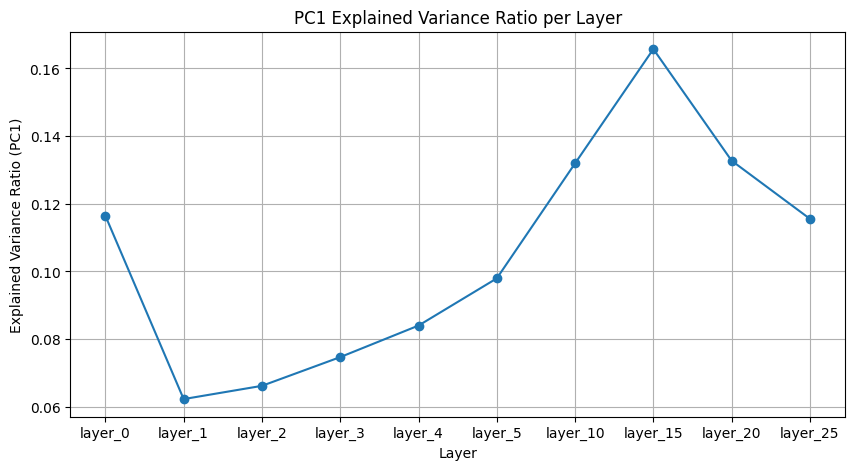

PCA plot saved to output/PCA/pca_plot.png


<Figure size 640x480 with 0 Axes>

In [ ]:
DIFF_DIR = "output/diff"
OUTPUT_DIR = "output/PCA"

%run -i scripts/parallel_runs/analyses/2_run_pca.py

=== PCA Results Summary ===
Type of PCA results: <class 'dict'> Type of PC1 vectors: <class 'dict'>
Total layers: 10

Layer layer_0: Explained variance ratios (top 3): [0.11645761 0.06845203 0.05567564] | First 3 elements: [0.00420641 0.0081569  0.00023104]

Layer layer_1: Explained variance ratios (top 3): [0.0622892  0.05848182 0.05259364] | First 3 elements: [-0.00199738 -0.00609975  0.00283743]

Layer layer_2: Explained variance ratios (top 3): [0.06620175 0.05629203 0.05363886] | First 3 elements: [ 0.00065405 -0.03322317  0.00553426]

Layer layer_3: Explained variance ratios (top 3): [0.07469117 0.05610298 0.05236498] | First 3 elements: [ 0.00359705 -0.01365492  0.00887355]

Layer layer_4: Explained variance ratios (top 3): [0.08401155 0.05613798 0.05328179] | First 3 elements: [0.00509608 0.00694182 0.0121408 ]

Layer layer_5: Explained variance ratios (top 3): [0.09795663 0.05621519 0.05526089] | First 3 elements: [0.00240218 0.00689817 0.01898637]

Layer layer_10: Explained v

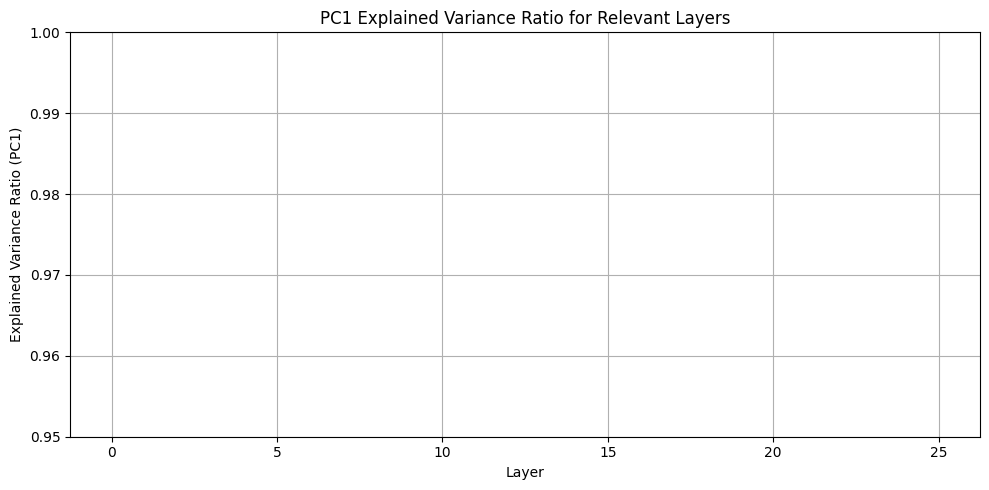

<Figure size 640x480 with 0 Axes>

In [ ]:
results_pt = "output/PCA/layer_pca_results.pt"
PC1_FILE = "output/PCA/layer_pc1_vectors.pt"

%run -i scripts/parallel_runs/analyses/3_pca_check.py